# HR Analytics

#### Imports

In [61]:
# Standard library imports
import os
import time
from collections import Counter

# Related third party imports
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import psycopg2
import seaborn as sns
from dotenv import load_dotenv
from scipy.stats import ttest_ind
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    average_precision_score,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
    matthews_corrcoef,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    RobustScaler,
    StandardScaler,
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Local application/library specific imports
from helpers import *

In [62]:
import warnings

warnings.filterwarnings("ignore")

start = "\033[1m"  # Bold text
end = "\033[0;0m"  # Reset text

In [63]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# https://www.kaggle.com/questions-and-answers/118932
# Max rows and columns of pandas dataframe
pd.options.display.max_rows, pd.options.display.max_columns

# https://thispointer.com/python-pandas-how-to-display-full-dataframe-i-e-print-all-rows-columns-without-truncation/
# Print all the contents of a pandas dataframe
pd.set_option(
    "display.max_rows", None
)  # Print unlimited number of rows by setting to None, default is 10
pd.set_option(
    "display.max_columns", None
)  # Do not truncate columns to display all of them by setting to None
pd.set_option(
    "display.width", None
)  # Auto-detect the width of dataframe to display all columns in single line by setting to None
pd.set_option(
    "display.max_colwidth", None
)  # Auto detect the max size of column and print contents of that column without truncation

(None, None)

#### Get the data from db

In [64]:
load_dotenv()

# Retrieve environment variables
DB_HOST = os.getenv("DB_HOST")
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")

# Connect to your postgres DB
conn = psycopg2.connect(
    host=DB_HOST, database=DB_NAME, user=DB_USER, password=DB_PASSWORD
)

# Open a cursor to perform database operations
cur = conn.cursor()

# Execute a query
cur.execute("SELECT * FROM hr_data")

# Fetch all rows from the table
rows = cur.fetchall()

# Get the column names
column_names = [desc[0] for desc in cur.description]

# Create a DataFrame from the rows and column names
df = pd.DataFrame(rows, columns=column_names)

# Close communication with the database
cur.close()
conn.close()

# Display the DataFrame
df.head()

del cur, conn, DB_HOST, DB_NAME, DB_USER, DB_PASSWORD, rows, column_names

True

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [65]:
df.rename(columns={"average_montly_hours": "average_monthly_hours"}, inplace=True)
df.rename(columns={"time_spend_company": "tenure"}, inplace=True)

#### Understanding the HR dataset

Variable  |Description |
-----|-----|
satisfaction_level|Employee-reported job satisfaction level [0&ndash;1]|
last_evaluation|Score of employee's last performance review [0&ndash;1]|
number_project|Number of projects employee contributes to|
average_monthly_hours|Average number of hours employee worked per month|
time_spend_company|How long the employee has been with the company (years)
Work_accident|Whether or not the employee experienced an accident while at work
left|Whether or not the employee left the company
promotion_last_5years|Whether or not the employee was promoted in the last 5 years
Department|The employee's department
salary|The employee's salary (U.S. dollars)

### Initial EDA and data cleaning

In [66]:
print(start + "Data Information post data type change:" + end)
df.info()

Data Information post data type change:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_monthly_hours  14999 non-null  int64  
 4   tenure                 14999 non-null  int64  
 5   work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [67]:
print(start + "Number of missing rows per column" + end)
df.isnull().sum()

Number of missing rows per column


satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
tenure                   0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

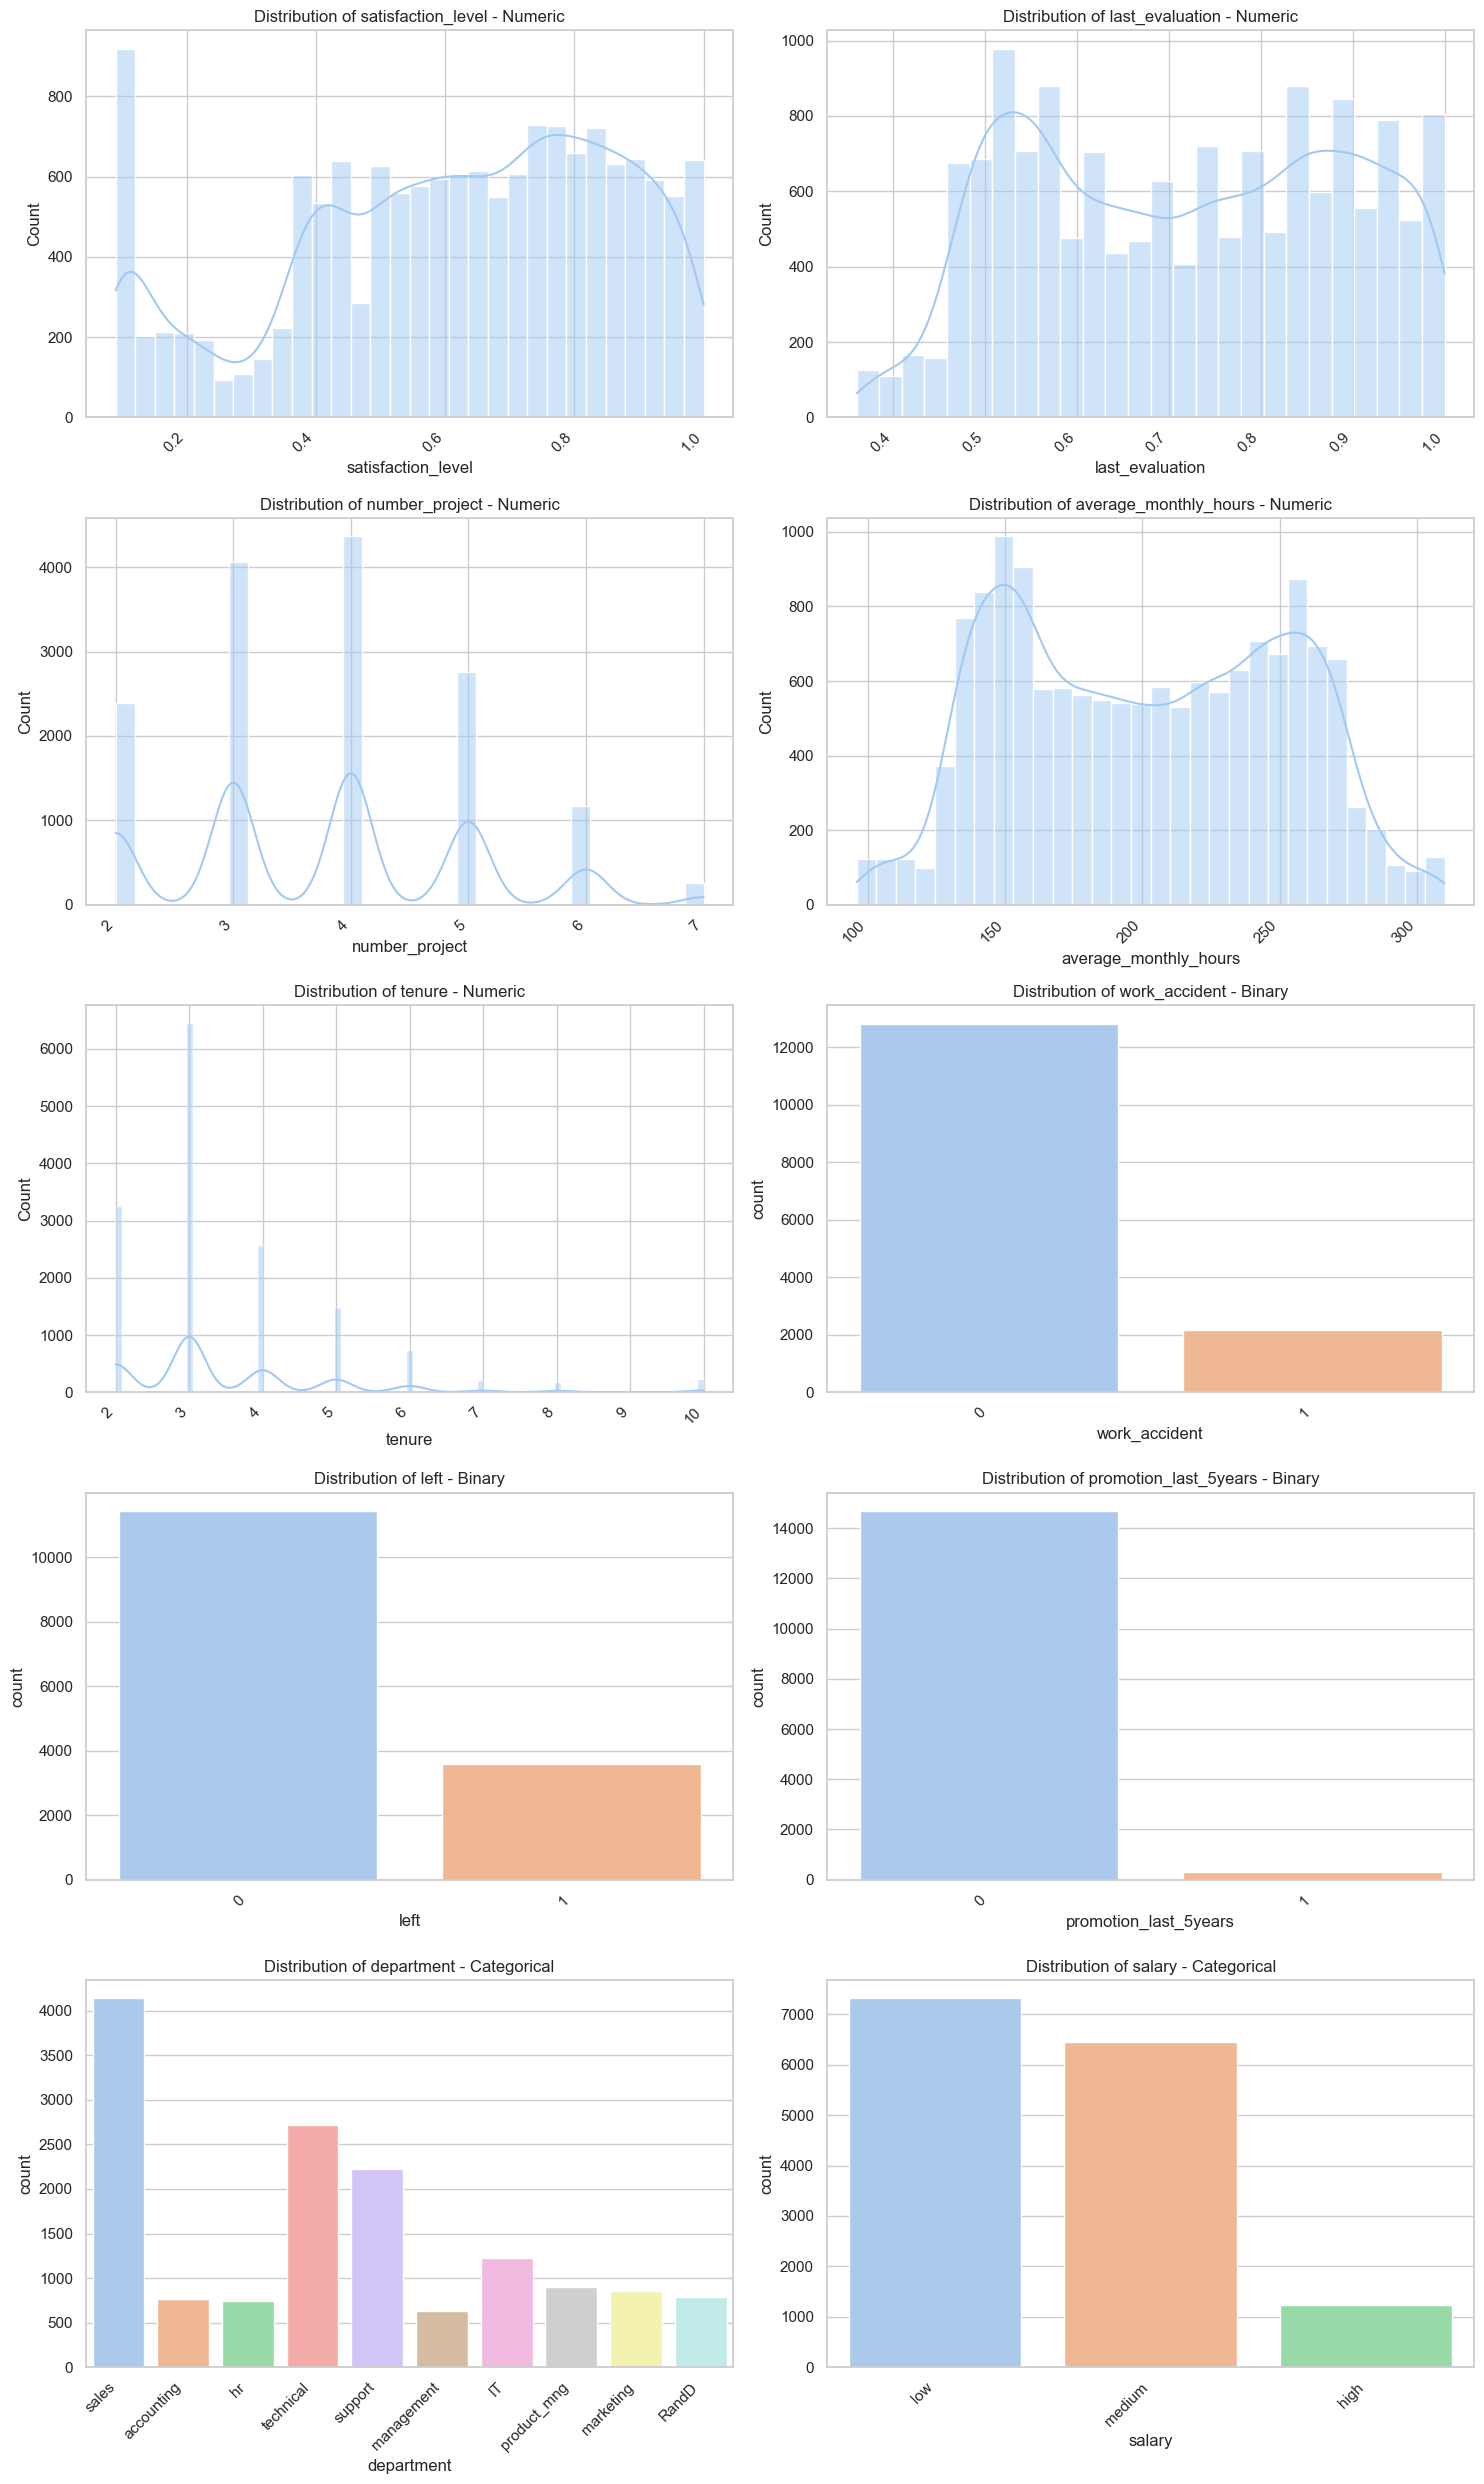

In [68]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")
sns.set_palette("pastel")
plot_data(df)

Initial observations of the data:
* About 14% of employees have experienced a work accident
* Almost 98% of employees did not recieve a promotion in the last 5 years
* Almost 24% of employees have left the company
* Majority of people have low and medium salaries

In [69]:
print(start + "Encoding salaries from low, medium, high to 0, 1, 2" + end)
df["salary"] = df["salary"].map({"low": 0.0, "medium": 1.0, "high": 2.0})
df.head()

Encoding salaries from low, medium, high to 0, 1, 2


,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,0.0
1,0.80,0.86,5,262,6,0,1,0,sales,1.0
2,0.11,0.88,7,272,4,0,1,0,sales,1.0
3,0.72,0.87,5,223,5,0,1,0,sales,0.0
4,0.37,0.52,2,159,3,0,1,0,sales,0.0


In [70]:
df.describe()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268,0.594706
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281,0.637183
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000,1.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000,2.000000


#### Check for any missing values in the data.

In [71]:
df.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
tenure                   0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

#### Check duplicates

In [72]:
df.duplicated().sum()

3008

In [73]:
# Inspect some rows containing duplicates as needed
duplicates = df.duplicated()
sorted_df = df.sort_values(by=df.columns.to_list())
sorted_df[:10]

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
30,0.09,0.62,6,294,4,0,1,0,accounting,0.0
12031,0.09,0.62,6,294,4,0,1,0,accounting,0.0
14243,0.09,0.62,6,294,4,0,1,0,accounting,0.0
71,0.09,0.77,5,275,4,0,1,0,product_mng,1.0
12072,0.09,0.77,5,275,4,0,1,0,product_mng,1.0
14284,0.09,0.77,5,275,4,0,1,0,product_mng,1.0
991,0.09,0.77,6,244,4,0,1,0,marketing,0.0
1212,0.09,0.77,6,244,4,0,1,0,product_mng,0.0
1192,0.09,0.77,6,256,5,0,1,0,support,1.0
1702,0.09,0.77,6,282,5,0,1,0,sales,1.0


In [74]:
df = df.drop_duplicates()
df.sort_values(by=df.columns.to_list())[:10]

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
30,0.09,0.62,6,294,4,0,1,0,accounting,0.0
71,0.09,0.77,5,275,4,0,1,0,product_mng,1.0
991,0.09,0.77,6,244,4,0,1,0,marketing,0.0
1212,0.09,0.77,6,244,4,0,1,0,product_mng,0.0
1192,0.09,0.77,6,256,5,0,1,0,support,1.0
1702,0.09,0.77,6,282,5,0,1,0,sales,1.0
653,0.09,0.77,6,290,4,0,1,0,technical,1.0
1483,0.09,0.77,6,310,4,0,1,0,hr,0.0
1054,0.09,0.78,6,244,4,0,1,0,IT,0.0
278,0.09,0.78,6,254,4,0,1,0,support,0.0


#### Check outliers

In [75]:
# Select numerical columns only
numeric_columns = df.select_dtypes(include=["number"])
outlier_df = display_outlier_percentage(numeric_columns)
outlier_df.sort_values(by="Percentage", ascending=False)

,Number of Outliers,Percentage
left,1991,16.604120
work_accident,1850,15.428238
tenure,824,6.871821
promotion_last_5years,203,1.692936
satisfaction_level,0,0.000000
last_evaluation,0,0.000000
number_project,0,0.000000
average_monthly_hours,0,0.000000
salary,0,0.000000


Text(0.5, 1.0, 'satisfaction_level')

Text(0.5, 1.0, 'last_evaluation')

Text(0.5, 1.0, 'number_project')

Text(0.5, 1.0, 'average_monthly_hours')

Text(0.5, 1.0, 'tenure')

Text(0.5, 1.0, 'work_accident')

Text(0.5, 1.0, 'left')

Text(0.5, 1.0, 'promotion_last_5years')

Text(0.5, 1.0, 'salary')

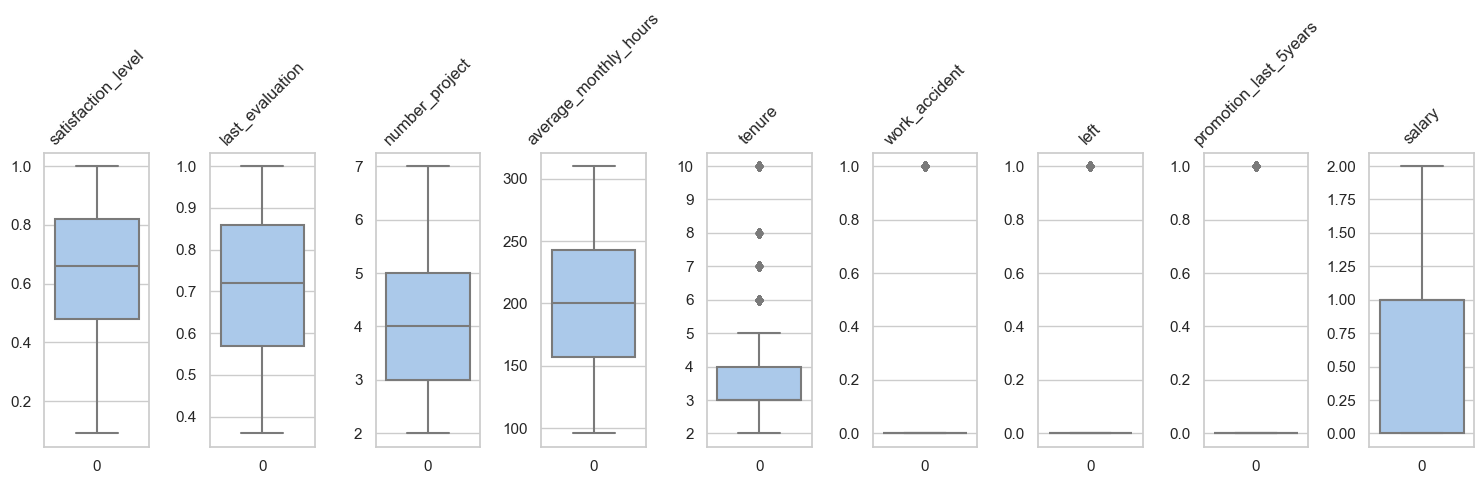

In [76]:
fig, axes = plt.subplots(nrows=1, ncols=len(numeric_columns.columns), figsize=(15, 5))
for i, column in enumerate(numeric_columns.columns):
    ax = sns.boxplot(data=numeric_columns[column], ax=axes[i])
    axes[i].set_title(f"{column}", rotation=45)

plt.tight_layout()
plt.show()
del numeric_columns, outlier_df

##### Tenure

In [77]:
fig = px.box(df, x="tenure", orientation="h")

# Update the layout of the figure
fig.update_layout(
    title="Distribution of Tenure",
    title_x=0.5,  # Center the title
    xaxis=dict(dtick=1),  # Increment the x-axis by one unit
    xaxis_title="Tenure (years)",
    yaxis_title="",
    height=400,  # Adjust the height
    width=600,  # Adjust the width)
)
del fig

In [78]:
Q1 = df["tenure"].quantile(0.25)
Q3 = df["tenure"].quantile(0.75)
IQR = Q3 - Q1
lower_fence = Q1 - 1.5 * IQR
upper_fence = Q3 + 1.5 * IQR

# Count the number of rows containing outliers
num_outliers = len(df[(df["tenure"] < lower_fence) | (df["tenure"] > upper_fence)])

# Print the result
print(start + "Number of rows containing outliers for tenure:", str(num_outliers) + end)

del Q1, Q3, IQR, lower_fence, upper_fence, num_outliers

Number of rows containing outliers for tenure: 824


In [79]:
df.head(10)

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,0.0
1,0.80,0.86,5,262,6,0,1,0,sales,1.0
2,0.11,0.88,7,272,4,0,1,0,sales,1.0
3,0.72,0.87,5,223,5,0,1,0,sales,0.0
4,0.37,0.52,2,159,3,0,1,0,sales,0.0
5,0.41,0.50,2,153,3,0,1,0,sales,0.0
6,0.10,0.77,6,247,4,0,1,0,sales,0.0
7,0.92,0.85,5,259,5,0,1,0,sales,0.0
8,0.89,1.00,5,224,5,0,1,0,sales,0.0
9,0.42,0.53,2,142,3,0,1,0,sales,0.0


### Correlation analysis

In [80]:
# Get numbers of people who left vs. stayed
print(start + "Number of people who left vs. stayed" + end)
df["left"].value_counts()

Number of people who left vs. stayed


left
0    10000
1     1991
Name: count, dtype: int64

In [81]:
# Create a plot as needed
numeric_df = df.select_dtypes(include=[np.number])  # type: ignore

correlation_matrix = numeric_df.corr()

mask = np.tril(np.ones_like(correlation_matrix, dtype=bool))
masked_correlation = correlation_matrix.where(~mask)

# Create heatmap for the upper triangular part
fig_upper = ff.create_annotated_heatmap(
    z=masked_correlation.values,
    x=list(masked_correlation.columns),
    y=list(masked_correlation.index),
    annotation_text=masked_correlation.round(2).values,
    colorscale="RdBu",
    reversescale=True,
    showscale=True,
)

# Update layout
fig_upper.update_layout(title="")

del fig_upper

There are some important correlations to be noted:
1. left and satisfaction_level: -35% negative correlation
2. average_monthy_hours and number_project : 33.1% correlated
3. number_project and last_evaluation: 27% correlated
4. average_monthly_hours and last_evaluation: 26% correlated

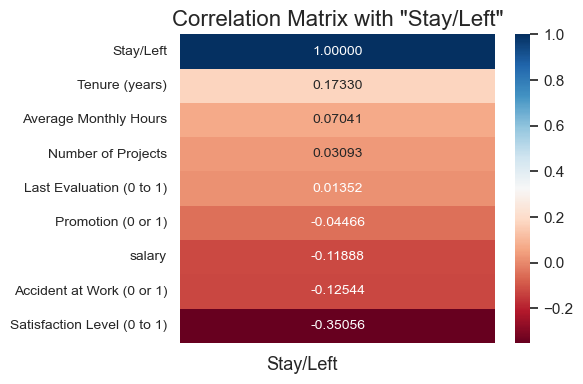

In [82]:
vars_lst = [
    "satisfaction_level",
    "last_evaluation",
    "number_project",
    "average_monthly_hours",
    "tenure",
    "work_accident",
    "promotion_last_5years",
    "salary",
]

corr_matrix = df[vars_lst + ["left"]].corr()

# Sort the correlation values in descending order
corr_sorted = corr_matrix["left"].sort_values(ascending=False)

plt.figure(figsize=(6, 4))
sns.heatmap(
    pd.DataFrame(corr_sorted),
    annot=True,
    cmap="RdBu",
    annot_kws={"size": 10},
    fmt=".5f",
)

label_map = {
    "satisfaction_level": "Satisfaction Level (0 to 1)",
    "last_evaluation": "Last Evaluation (0 to 1)",
    "number_project": "Number of Projects",
    "average_monthly_hours": "Average Monthly Hours",
    "tenure": "Tenure (years)",
    "work_accident": "Accident at Work (0 or 1)",
    "promotion_last_5years": "Promotion (0 or 1)",
    "salary_encoded": "Salary (0,1,2)",
    "left": "Stay/Left",
}

ax = plt.gca()
ax.set_xticklabels(["Stay/Left"], ha="right", fontsize=13)
ax.set_yticklabels(
    [label_map.get(var, var) for var in corr_sorted.index], rotation=0, fontsize=10
)
del corr_matrix, label_map, ax
plt.title('Correlation Matrix with "Stay/Left"', fontsize=16)

plt.tight_layout()
plt.show();

Interpretation:
- Tenure: The correlation of 0.17 indicates that there is a weak tendancy for people that have been with the company for a long time to leave.
- Satisfaction level: The negative correlation of -0.35 indicates that less satisfied employees are more likely to leave. However, this is not a very strong inverse correlation.

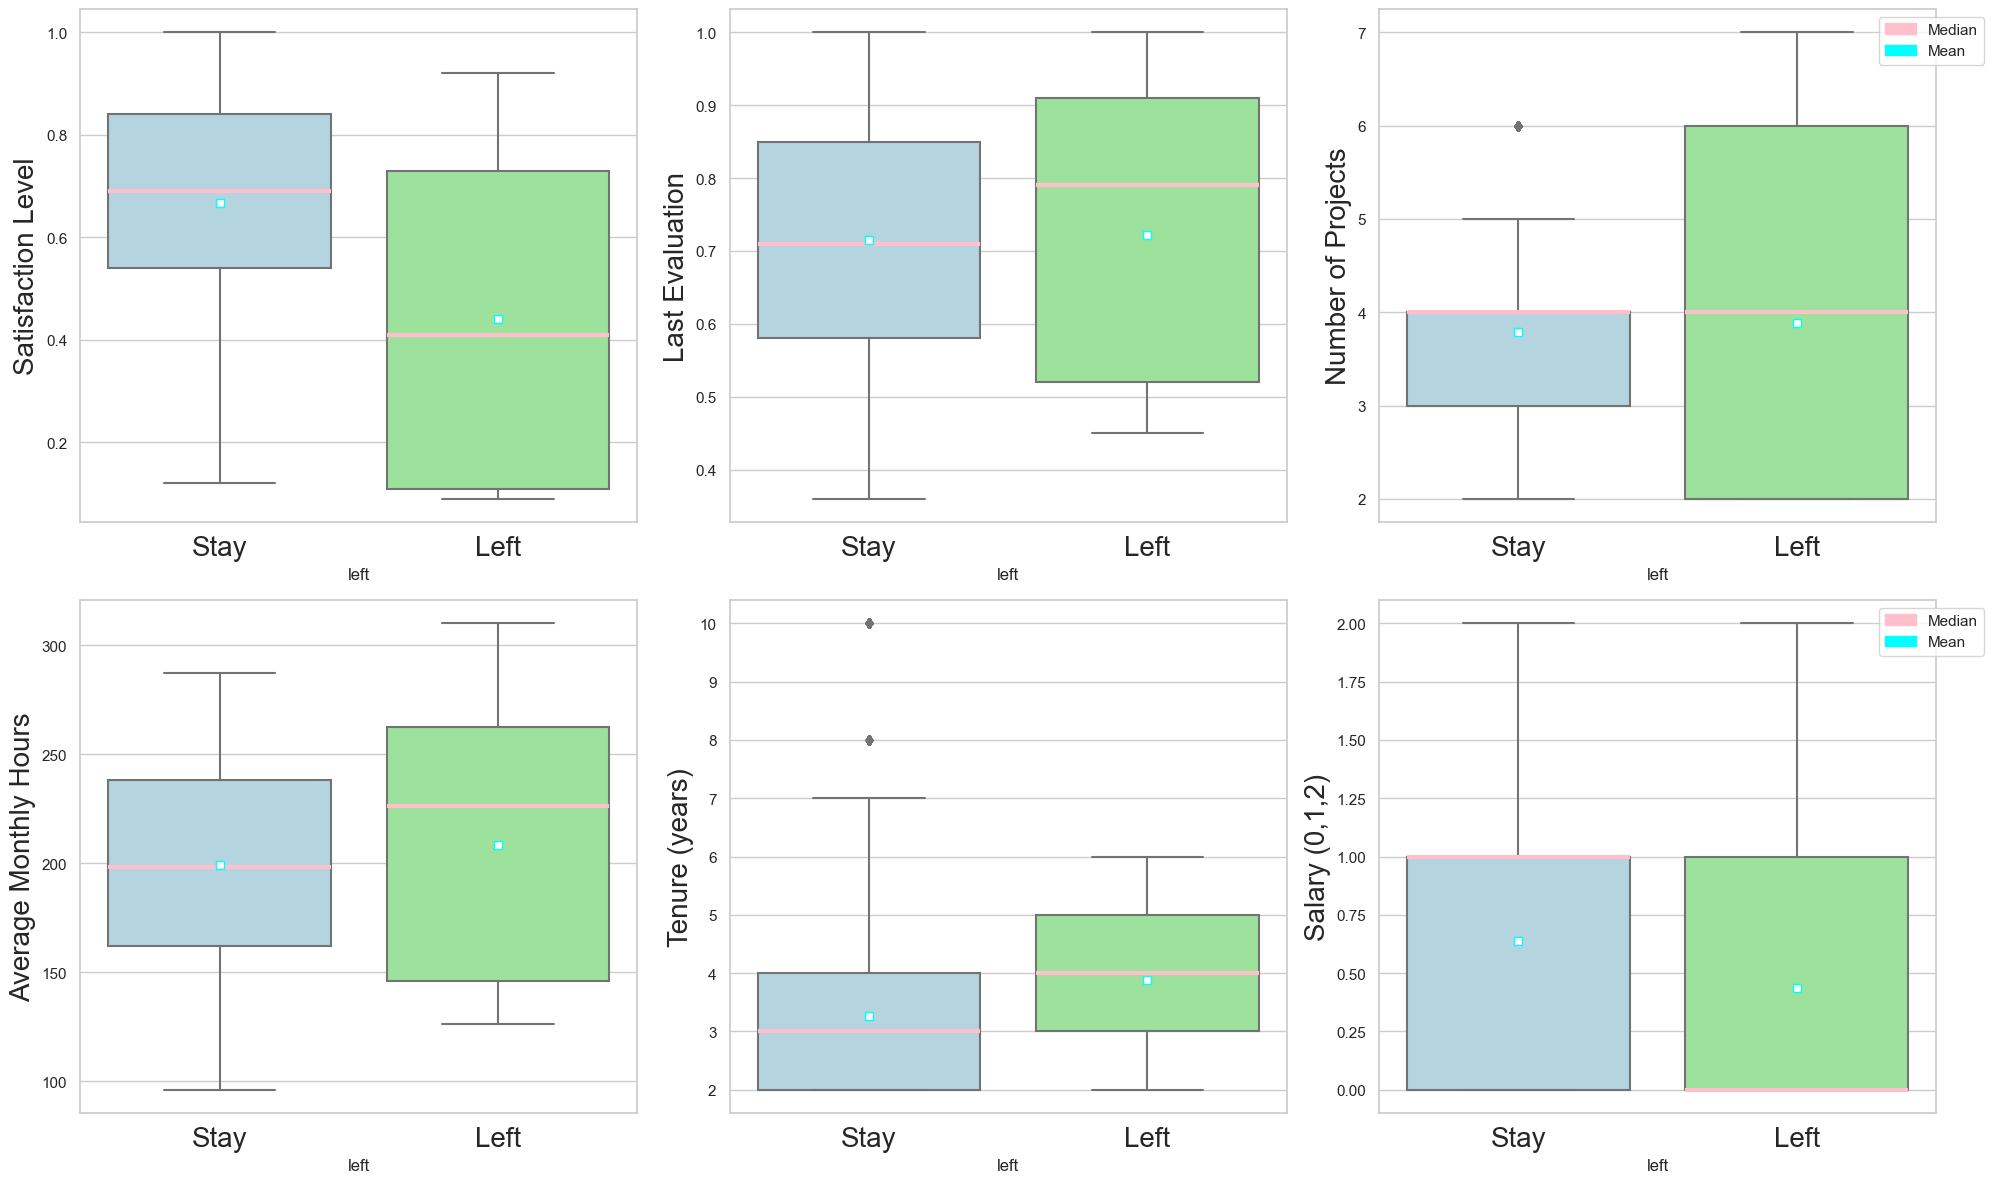

In [83]:
# Setting the style for seaborn
sns.set_style("whitegrid")

# Create the figure and axes for subplot
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))

numeric_lst = [
    "satisfaction_level",
    "last_evaluation",
    "number_project",
    "average_monthly_hours",
    "tenure",
    "salary",
]
y_axis = [
    "Satisfaction Level",
    "Last Evaluation",
    "Number of Projects",
    "Average Monthly Hours",
    "Tenure (years)",
    "Salary (0,1,2)",
]
median_patch = mpatches.Patch(color="pink", label="Median")
mean_patch = mpatches.Patch(color="Cyan", label="Mean")

for idx, feature in enumerate(numeric_lst):
    # Determine the subplot indices
    row_idx = idx // 3
    col_idx = idx % 3

    # Using seaborn to create the boxplots
    sns.boxplot(
        x="left",
        y=feature,
        data=df,
        ax=ax[row_idx, col_idx],
        palette=["lightblue", "lightgreen"],
        showmeans=True,
        meanprops={
            "marker": "s",
            "markerfacecolor": "white",
            "markeredgecolor": "Cyan",
        },
        medianprops={"color": "pink", "linewidth": 3},
    )

    # Setting the y-axis label and x-axis labels
    ax[row_idx, col_idx].set_ylabel(y_axis[idx], size=20)
    ax[row_idx, col_idx].set_xticklabels(["Stay", "Left"], size=20)

    # Check if there are any artists for median
    median_artists = ax[row_idx, col_idx].artists
    median_line = median_artists[0] if median_artists else None

    # Check if there are any lines for mean
    mean_lines = [
        line
        for line in ax[row_idx, col_idx].get_lines()
        if line.get_markerfacecolor() == "white"
    ]
    mean_line = mean_lines[0] if mean_lines else None

    # Create legend only if median and mean are present
    if median_line and mean_line:
        ax[row_idx, col_idx].legend(
            [median_line, mean_line],
            ["Median", "Mean"],
            loc="upper right",
        )
    if col_idx == 2:  # This assumes there are 3 columns
        ax[row_idx, col_idx].legend(
            handles=[median_patch, mean_patch],
            loc="upper right",
            bbox_to_anchor=(1.1, 1),
        )


plt.tight_layout()
plt.show();

In [84]:
pdf = df.copy()
pdf.drop(
    ["work_accident", "promotion_last_5years", "department", "salary"],
    axis=1,
    inplace=True,
)
pdf = (
    pd.concat(
        [
            pdf,
            df.drop(
                ["work_accident", "promotion_last_5years", "department", "salary"],
                axis=1,
            ),
        ],
        ignore_index=True,
    )
    .groupby("left")
    .describe()
    .sort_index()
)

pdf = pdf.unstack().unstack(1).sort_index(level=[0, 1])
pdf = pdf[["count", "mean", "std", "min", "25%", "50%", "75%", "max"]]
sumstatsfmt(pdf)

n     Mean      SD  Min       Q1   Median  \
                      left                                                   
Average Monthly Hours Stay  20,000  198.943  45.664   96  162.000  198.000   
                      Left   3,982  208.162  61.287  126  146.000  226.000   
Last Evaluation       Stay  20,000    0.716   0.162    0    0.580    0.710   
                      Left   3,982    0.722   0.197    0    0.520    0.790   
Number of Projects    Stay  20,000    3.787   0.982    2    3.000    4.000   
                      Left   3,982    3.883   1.817    2    2.000    4.000   
Satisfaction Level    Stay  20,000    0.667   0.217    0    0.540    0.690   
                      Left   3,982    0.440   0.265    0    0.110    0.410   
Tenure (years)        Stay  20,000    3.262   1.367    2    2.000    3.000   
                      Left   3,982    3.881   0.974    2    3.000    4.000   

                                 Q3  Max  
                      left                
Average Monthly Hours Stay  238.000  287  
                      Left  262.750  310  
Last Evaluation       Stay    0.850    1  
                      Left    0.910    1  
Number of Projects    Stay    4.000    6  
                      Left    6.000    7  
Satisfaction Level    Stay    0.840    1  
                      Left    0.730    1  
Tenure (years)        Stay    4.000   10  
                      Left    5.000    6

Which of these differences are statistically significant?

In [85]:
p_values = {}

for feature in numeric_lst:
    group_stay = df[df["left"] == 0][feature]
    group_left = df[df["left"] == 1][feature]

    t_stat, p_val = ttest_ind(group_stay, group_left, equal_var=True)
    p_values[feature] = p_val

p_value_df = pd.DataFrame(
    {
        "Numerical features": numeric_lst,
        "p-value": [p_values[feature] for feature in numeric_lst],
        "statistically significant (a = 0.05)": [
            p_values[feature] < 0.05 for feature in numeric_lst
        ],
    }
)

p_value_df.set_index("Numerical features", inplace=True)
p_value_df.sort_values(["p-value"])

,p-value,statistically significant (a = 0.05)
Numerical features,,
satisfaction_level,0.000000e+00,True
tenure,1.745811e-81,True
salary,5.360173e-39,True
average_monthly_hours,1.173939e-14,True
number_project,7.062542e-04,True
last_evaluation,1.387695e-01,False


### Comparing the characteristics of employees who left with those who stayed. Here are the key findings:

- **Satisfaction Level:**  There is a statistically significant difference in the satisfaction levels of employees who left and those who stayed. Employees who left the company tend to have a lower satisfaction level.
- **Tenure (years):** There's a statistically significant difference in tenure between the groups. Employees who left have slightly higher tenure compared to those who stayed.
- **Salary Level:** There's a significant difference in the salary levels of the two groups.
- **Average Monthly Hours**: Employees who left tend to work more hours on average, and this difference is statistically significant.
- **Number of Projects**:  Employees who left have a statistically significant difference in the number of projects they were involved in.
- **Last Evaluation:** While there's a slight difference in the last evaluation scores between the two groups, this difference is not statistically significant. This suggests that the quality of work (as measured by the last evaluation) might not be a strong predictor for an employee's decision to leave.

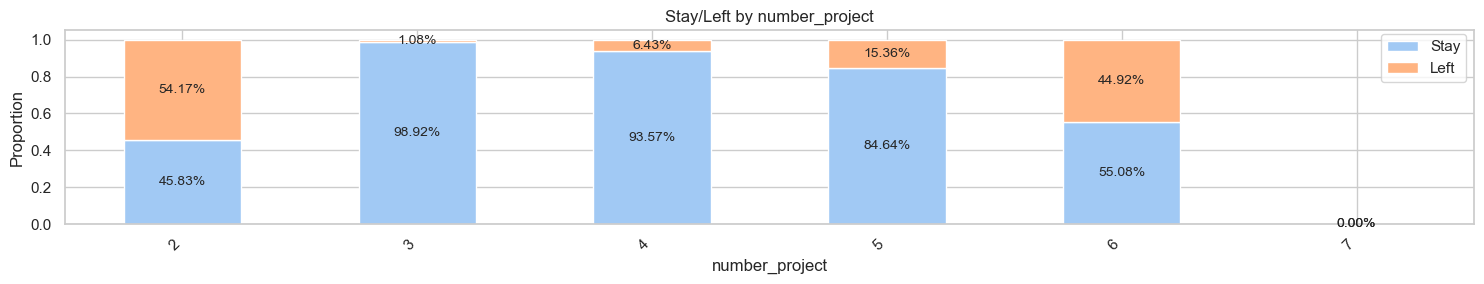

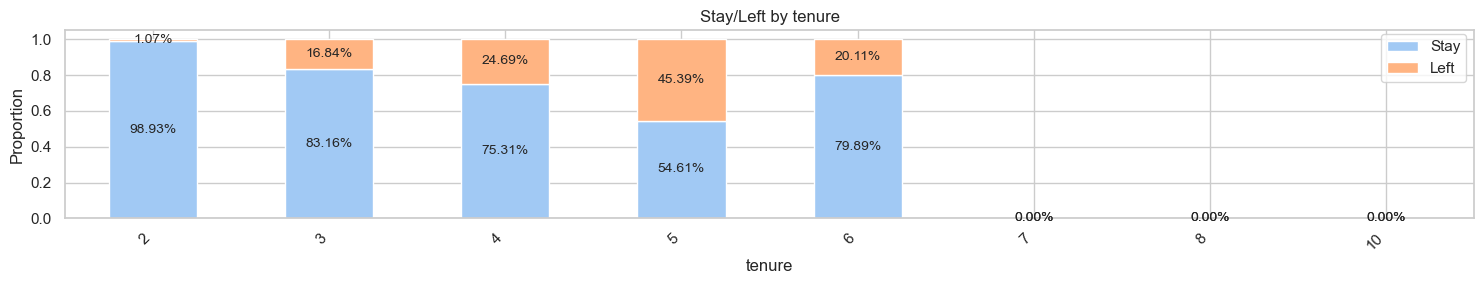

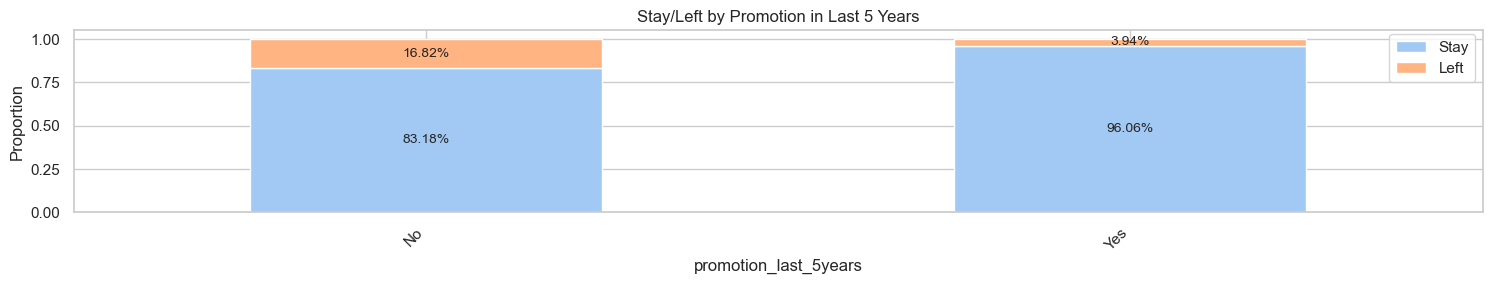

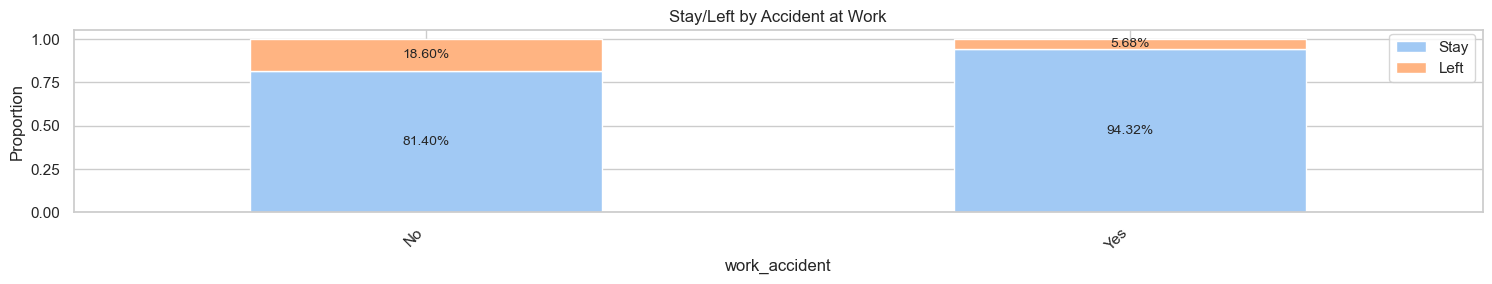

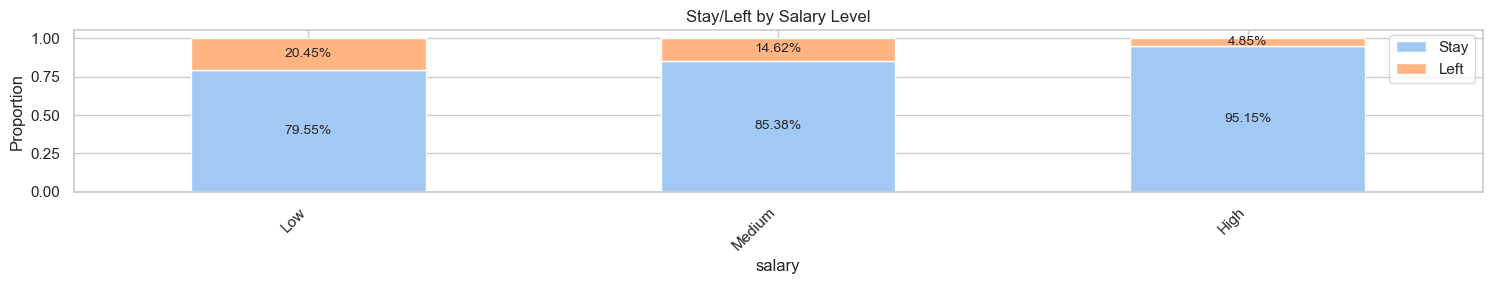

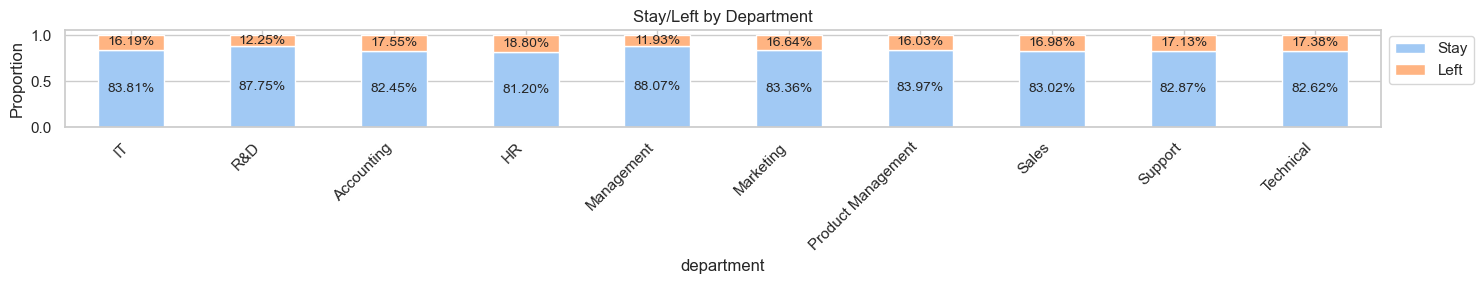

In [86]:
# Mapping dictionaries
vars_list = [
    "number_project",
    "tenure",
    "promotion_last_5years",
    "work_accident",
    "salary",
    'department'
]
department_labels = {
    "sales": "Sales",
    "technical": "Technical",
    "support": "Support",
    "IT": "IT",
    "product_mng": "Product Management",
    "marketing": "Marketing",
    "RandD": "R&D",
    "accounting": "Accounting",
    "hr": "HR",
    "management": "Management",
}
binary_labels = {0: "No", 1: "Yes"}
salary_labels = {0: "Low", 1: "Medium", 2: "High"}

# Labels for variables
var_labels = {
    "department": department_labels,
    "work_accident": binary_labels,
    "promotion_last_5years": binary_labels,
    "salary": salary_labels,
}
# Human-readable labels for variables
var_titles = {
    "department": "Department",
    "work_accident": "Accident at Work",
    "promotion_last_5years": "Promotion in Last 5 Years",
    "salary": "Salary Level",
}
for var in vars_list:
    labels_map = var_labels.get(var, {})
    title = "Stay/Left by " + var_titles.get(var, var)
    plot_attrition_by_variable(df, var, labels_map, title)

### Findings
- Surprisingly, the proportion of employees leaving is lower for those who had an accident at work (5.68%) compared to those who did not (18.60%).
- The proportion of employees leaving is lower for those who received a promotion in the last five years i.e. 3.94% compared to those who did not receive a promotion i.e. 16.82%.
- The proportion of employees leaving is the lowest among the high salary group i.e. 4.85%, followed by the medium salary group i.e. 14.62% and the low salary group i.e. 20.45%. This relationship is also depicted in the previous boxplot visualization of salary.
- When breaking down by individual departments, many departments, including 'Sales', 'Technical', and 'Support', did not show a significant difference in the distribution of employees who stayed and left on their own.


-> Plotting evaluation of employees based on wether they left or not and the average number of working hours

-> Plotting satisfaction of employees based on wether they left or not and the average number of working hours

### Overtime analysis

In [87]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,0.0
1,0.80,0.86,5,262,6,0,1,0,sales,1.0
2,0.11,0.88,7,272,4,0,1,0,sales,1.0
3,0.72,0.87,5,223,5,0,1,0,sales,0.0
4,0.37,0.52,2,159,3,0,1,0,sales,0.0


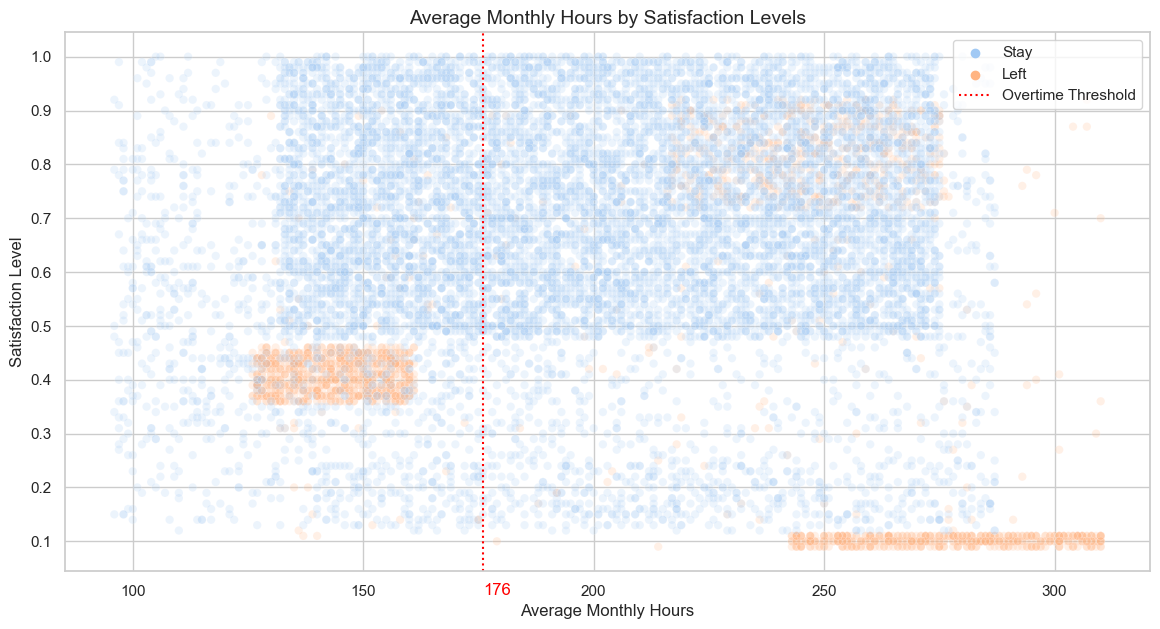

In [88]:
generate_scatterplt(
    df,
    "average_monthly_hours",
    "satisfaction_level",
    "Average Monthly Hours",
    "Satisfaction Level",
    "Average Monthly Hours by Satisfaction Levels",
    176,
    0,
)


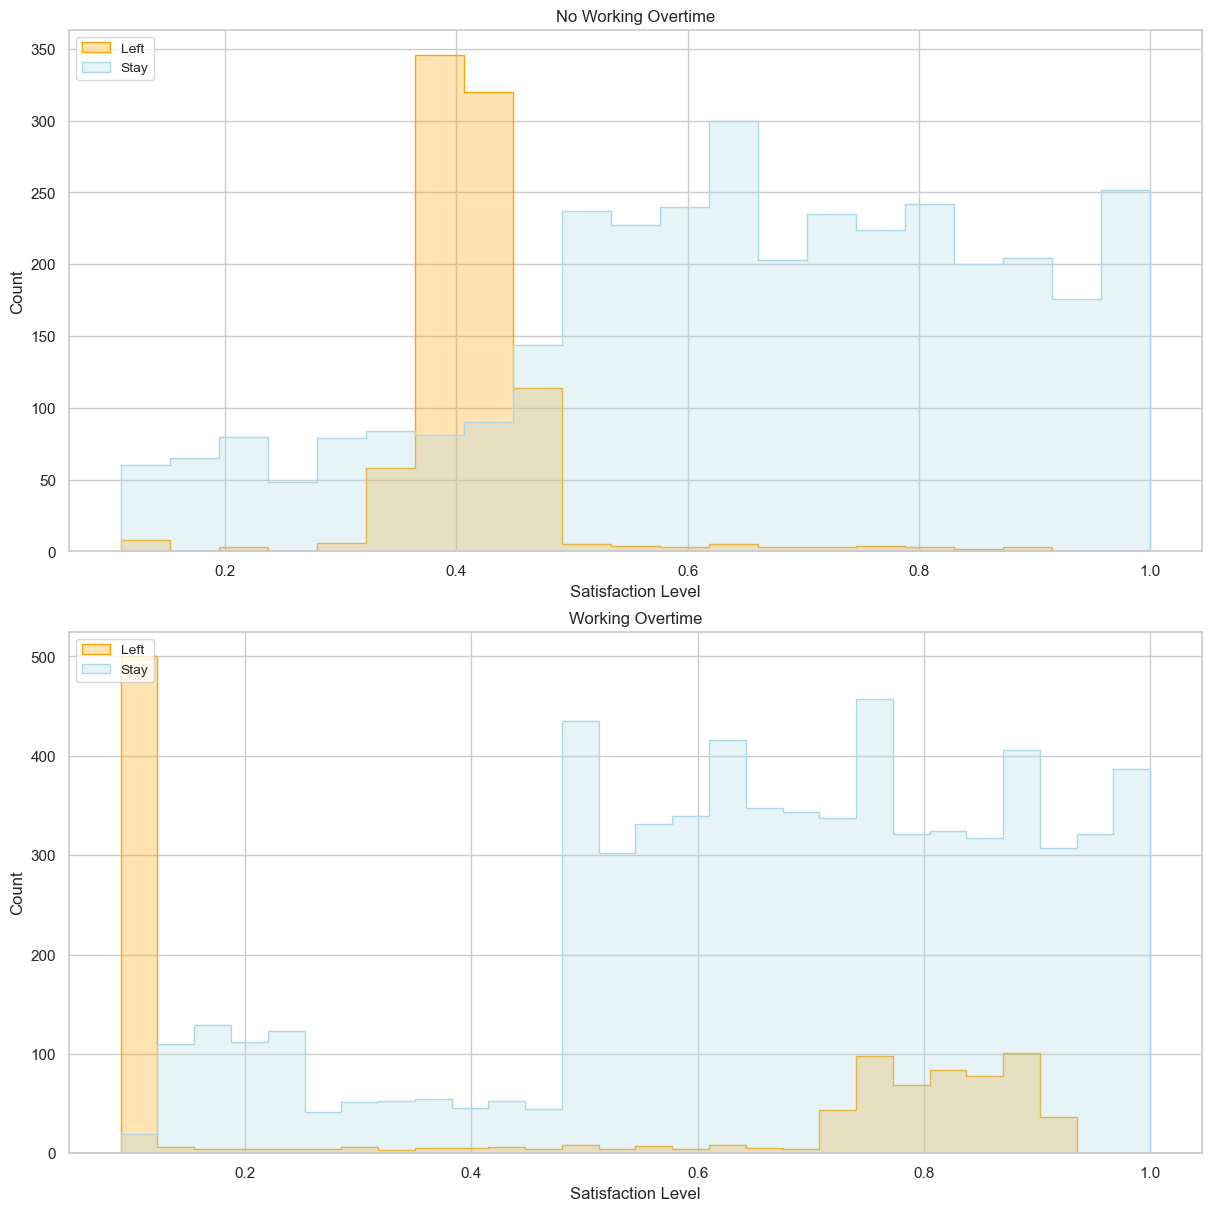

In [89]:
# Call the main function to create histograms
threshold_value = 176
feature_to_evaluate = "average_monthly_hours"
target_column = "left"
colors = ["lightblue", "orange"]
create_overtime_histograms(
    df, threshold_value, feature_to_evaluate, target_column, colors
)

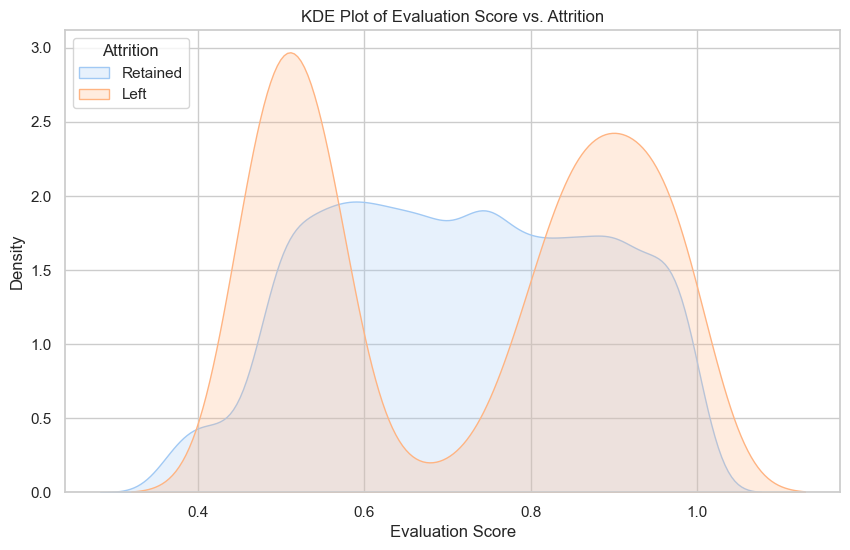

In [90]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df[df["left"] == 0]["last_evaluation"], label="Retained", fill=True)
sns.kdeplot(data=df[df["left"] == 1]["last_evaluation"], label="Left", fill=True)
plt.title("KDE Plot of Evaluation Score vs. Attrition")
plt.xlabel("Evaluation Score")
plt.ylabel("Density")
plt.legend(title="Attrition", loc="upper left", labels=["Retained", "Left"])
plt.show();

From the histograms, we can observe the distribution of satisfaction levels among employees based on whether they worked overtime and whether they stayed with the company or left.
- Employees not working overtime tend to leave when their satisfaction level is around 0.4.
- Among those doing overtime, two groups are prominent: one with very low satisfaction and another around a 0.8 satisfaction level, both showing a higher likelihood to quit.

# Modelling

### Logistic Regression


**Logistic Regression model assumptions**
- Outcome variable is categorical
- Observations are independent of each other
- No severe multicollinearity among X variables
- No extreme outliers
- Linear relationship between each X variable and the logit of the outcome variable
- Sufficiently large sample size





In [91]:
logistic_regression_assumptions(df, 'left')

The outcome variable is binary or categorical.
Ensure that the observations are independent.
                   feature        VIF
0       satisfaction_level   7.124816
1          last_evaluation  19.999420
2           number_project  13.898636
3    average_monthly_hours  40.629874
4                   tenure   7.503767
5            work_accident   1.183718
6    promotion_last_5years   1.042266
7                   salary   1.921231
8                 overtime   6.692761
9         department_RandD   1.589814
10   department_accounting   1.530619
11           department_hr   1.498438
12   department_management   1.419240
13    department_marketing   1.573761
14  department_product_mng   1.575970
15        department_sales   3.732937
16      department_support   2.541756
17    department_technical   2.896178
Found 378 extreme outliers
The sample size is sufficiently large.


In [92]:
X_train_enc, X_test_enc, y_train, y_test = prepare_data(df, "left", lr=True)
print_dataset_summary(X_train_enc, X_test_enc, y_train, y_test)

------Summary------
Training set:
9592 entries, 18 columns
Stay = 83.3924%, Left = 16.6076%

Test set:
2399 entries, 18 columns
Stay = 83.4098%, Left = 16.5902%


In [93]:
X_train_enc.head(5)

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,promotion_last_5years,salary,overtime,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
2032,0.52,0.88,3,179,2,1,0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10435,0.75,0.71,5,147,4,1,0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021,0.61,0.98,3,267,3,0,0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11597,0.56,0.39,3,106,8,0,0,2.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1999,0.99,0.91,5,136,4,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [94]:
scalers_list = [None, MinMaxScaler, RobustScaler, StandardScaler]
numeric_features_list = [
    "satisfaction_level",
    "tenure",
    "work_accident",
    "promotion_last_5years",
    "salary",
    "department_RandD",
    "department_accounting",
    "department_hr",
    "department_management",
    "department_marketing",
    "department_product_mng",
    "department_sales",
    "department_support",
    "department_technical",
]

start_lr = time.time()
results, creport, cmatrix = model_assessment_pipeline(
    X_train_enc, y_train, X_test_enc, y_test, scalers_list, numeric_features_list
)
end_lr = time.time()

# Output the results
results_df_lr = pd.DataFrame(results)
creport_df = pd.concat(creport, axis=1)
cmatrix_df = pd.concat(cmatrix, axis=1)
results_df_lr

,No Scaling,MinMaxScaler,RobustScaler,StandardScaler
ROC AUC,0.861282,0.862172,0.852515,0.862143
AP,0.424623,0.434434,0.396466,0.429008
Balanced accuracy,0.824492,0.820224,0.816948,0.824728
G-mean,0.822982,0.818898,0.815976,0.823521
Youden's index,0.648985,0.640447,0.633895,0.649457
MCC,0.512231,0.505652,0.502242,0.514739
Training_time,0.517838,0.370838,0.492633,0.480079


In [95]:
creport_df

No Scaling                                  MinMaxScaler  \
              precision    recall  f1-score      support    precision   
Stay           0.968750  0.774613  0.860872  2001.000000     0.966896   
Left           0.435544  0.874372  0.581454   398.000000     0.432331   
accuracy       0.791163  0.791163  0.791163     0.791163     0.789079   
macro avg      0.702147  0.824492  0.721163  2399.000000     0.699613   
weighted avg   0.880290  0.791163  0.814516  2399.000000     0.878210   

                                              RobustScaler            \
                recall  f1-score      support    precision    recall   
Stay          0.773613  0.859522  2001.000000     0.964640  0.777111   
Left          0.866834  0.576923   398.000000     0.433291  0.856784   
accuracy      0.789079  0.789079     0.789079     0.790329  0.790329   
macro avg     0.820224  0.718223  2399.000000     0.698966  0.816948   
weighted avg  0.789079  0.812639  2399.000000     0.876488  0.790329   

                                    StandardScaler                      \
              f1-score      support      precision    recall  f1-score   
Stay          0.860781  2001.000000       0.967762  0.780110  0.863863   
Left          0.575527   398.000000       0.440204  0.869347  0.584459   
accuracy      0.790329     0.790329       0.794915  0.794915  0.794915   
macro avg     0.718154  2399.000000       0.703983  0.824728  0.724161   
weighted avg  0.813456  2399.000000       0.880239  0.794915  0.817509   

                           
                  support  
Stay          2001.000000  
Left           398.000000  
accuracy         0.794915  
macro avg     2399.000000  
weighted avg  2399.000000

In [96]:
cmatrix_df

No Scaling      MinMaxScaler      RobustScaler      StandardScaler     
           Stay Left         Stay Left         Stay Left           Stay Left
Stay       1550  451         1548  453         1555  446           1561  440
Left         50  348           53  345           57  341             52  346

In [97]:
full_report_df_lr = pd.concat(
    [creport_df["StandardScaler"], results_df_lr["StandardScaler"]], axis=1
)
full_report_df_lr

,precision,recall,f1-score,support,StandardScaler
Stay,0.967762,0.780110,0.863863,2001.000000,NaN
Left,0.440204,0.869347,0.584459,398.000000,NaN
accuracy,0.794915,0.794915,0.794915,0.794915,NaN
macro avg,0.703983,0.824728,0.724161,2399.000000,NaN
weighted avg,0.880239,0.794915,0.817509,2399.000000,NaN
ROC AUC,NaN,NaN,NaN,NaN,0.862143
AP,NaN,NaN,NaN,NaN,0.429008
Balanced accuracy,NaN,NaN,NaN,NaN,0.824728
G-mean,NaN,NaN,NaN,NaN,0.823521
Youden's index,NaN,NaN,NaN,NaN,0.649457


**Overall Interpretation:**

- The scaling of data appears to have a marginal impact on the model's performance, with MinMaxScaler and StandardScaler showing slightly better performance metrics compared to no scaling.
- The training time is notably improved with scaled data, which can be a crucial factor in larger datasets or real-time systems.

### Tree based clasifiers

In [98]:
y = df.left
X = df[
    [
        "satisfaction_level",
        "last_evaluation",
        "number_project",
        "average_monthly_hours",
        "tenure",
        "work_accident",
        "promotion_last_5years",
        "department",
        "salary",
    ]
]

X_enc = X.copy()
X_enc["department"] = LabelEncoder().fit_transform(X["department"])

X_train_enc, X_test_enc, y_train, y_test = train_test_split(
    X_enc,
    y,
    test_size=0.20,  # Proportion of test set
    random_state=42,  # For reproducibility
    shuffle=True,  # Shuffle the data before splitting
    stratify=y,
)
print(start + "------Summary------" + end)
print("Training set:")
print(X_train_enc.shape[0], "entries,", X_train_enc.shape[1], "columns")

uniq_train, cnt_train = np.unique(y_train, return_counts=True)
pct_train = dict(zip(uniq_train, cnt_train * 100 / len(y_train)))
print(f"Stay = {pct_train[0]:.4f}%" + f", Left = {pct_train[1]:.4f}%")

print()

print("Test set:")
print(X_test_enc.shape[0], "entries,", X_test_enc.shape[1], "columns")

uniq_test, cnt_test = np.unique(y_test, return_counts=True)
pct_test = dict(zip(uniq_test, cnt_test * 100 / len(y_test)))
print(f"Stay = {pct_test[0]:.4f}%" + f", Left = {pct_test[1]:.4f}%")

del uniq_train, cnt_train, uniq_test, cnt_test

------Summary------
Training set:
9592 entries, 9 columns
Stay = 83.3924%, Left = 16.6076%

Test set:
2399 entries, 9 columns
Stay = 83.4098%, Left = 16.5902%


#### XGBoost

In [99]:
counter = Counter(y_train)

estimate = counter[0] / counter[1]
start_xgb = time.time()
xgb = XGBClassifier(
    objective="binary:logistic", random_state=42
).fit(X_train_enc, y_train)
end_xgb = time.time()

print("XGBoost: Training time (seconds) =", format(end_xgb - start_xgb))

XGBoost: Training time (seconds) = 0.17765021324157715


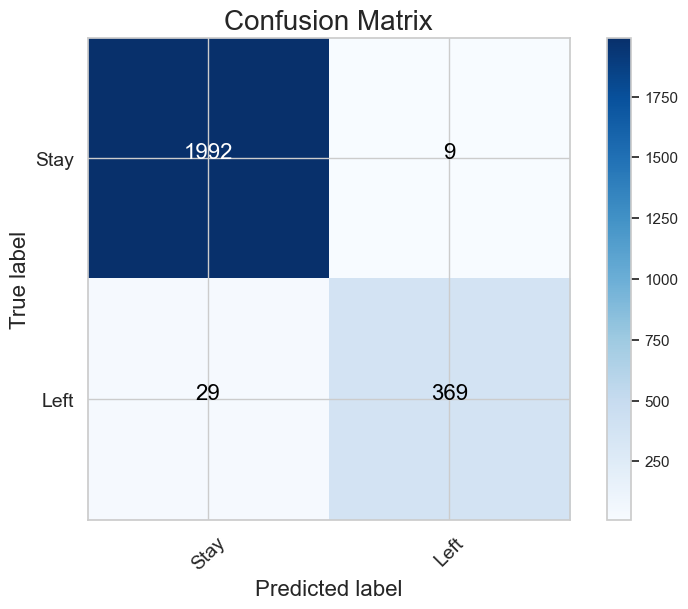

In [100]:
y_pred_xgb = xgb.predict(X_test_enc)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
class_names = ["Stay", "Left"]
plot_confusion_matrix(cm_xgb, class_names)

In [101]:
print(start + "Classification Report for XGBoost" + end)
target_names = ['Stay','Left']

report_df = generate_classification_report(y_test, y_pred_xgb, target_names)

# Calculate performance metrics and store them in a DataFrame
metrics_df = calculate_performance_metrics(xgb, X_test_enc, y_test, y_pred_xgb)

# Combine both DataFrames for a full report
full_report_df_xgb = pd.concat([report_df, metrics_df], axis=0)

full_report_df_xgb


Classification Report for XGBoost


,precision,recall,f1-score,support,ROC AUC,AP,Balanced accuracy,G-mean,Youden's index,MCC
Stay,0.985651,0.995502,0.990552,2001.00000,NaN,NaN,NaN,NaN,NaN,NaN
Left,0.976190,0.927136,0.951031,398.00000,NaN,NaN,NaN,NaN,NaN,NaN
accuracy,0.984160,0.984160,0.984160,0.98416,NaN,NaN,NaN,NaN,NaN,NaN
macro avg,0.980921,0.961319,0.970791,2399.00000,NaN,NaN,NaN,NaN,NaN,NaN
weighted avg,0.984081,0.984160,0.983995,2399.00000,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,0.982725,0.967798,0.961319,0.960711,0.922638,0.942036


#### LightGBM

[LightGBM] [Info] Number of positive: 1593, number of negative: 7999
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 9592, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166076 -> initscore=-1.613698
[LightGBM] [Info] Start training from score -1.613698
LightGBM classifier: Training time (seconds): 0.1175699234008789


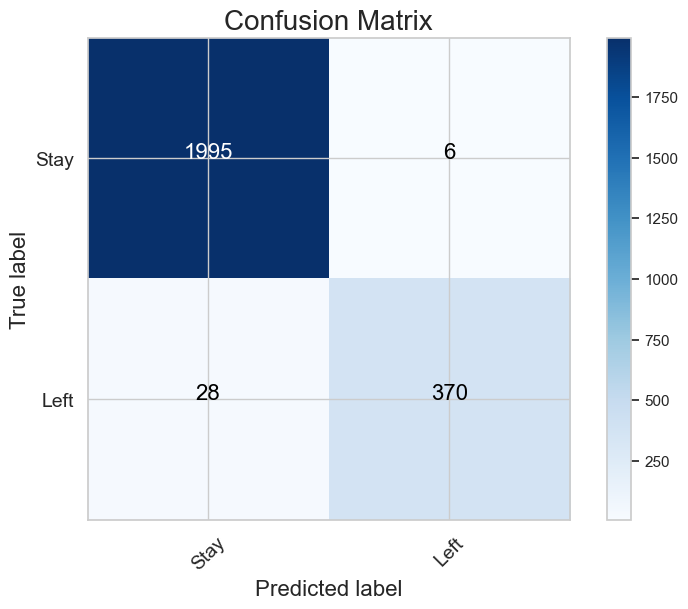

In [102]:
start_lgbmc = time.time()
lgbmc = LGBMClassifier(n_jobs=-1, random_state=42).fit(X_train_enc, y_train)
end_lgbmc = time.time()

print(
    "LightGBM classifier: Training time (seconds):",
    format(end_lgbmc - start_lgbmc),
)
class_labels = ["Stay", "Left"]
y_pred_lgbmc = lgbmc.predict(X_test_enc)
cm_lgbmc = confusion_matrix(y_test, y_pred_lgbmc)

class_names = ["Stay", "Left"]
plot_confusion_matrix(cm_lgbmc, class_names)

In [103]:
print(start + "\nLGMB Classification Report:" + end)
target_names = ["Stay", "Left"]

report_df = generate_classification_report(y_test, y_pred_lgbmc, target_names)

# Calculate performance metrics and store them in a DataFrame
metrics_df = calculate_performance_metrics(xgb, X_test_enc, y_test, y_pred_lgbmc)

# Combine both DataFrames for a full report
full_report_df_lgb = pd.concat([report_df, metrics_df], axis=0)

full_report_df_lgb


LGMB Classification Report:


,precision,recall,f1-score,support,ROC AUC,AP,Balanced accuracy,G-mean,Youden's index,MCC
Stay,0.986159,0.997001,0.991551,2001.000000,NaN,NaN,NaN,NaN,NaN,NaN
Left,0.984043,0.929648,0.956072,398.000000,NaN,NaN,NaN,NaN,NaN,NaN
accuracy,0.985827,0.985827,0.985827,0.985827,NaN,NaN,NaN,NaN,NaN,NaN
macro avg,0.985101,0.963325,0.973812,2399.000000,NaN,NaN,NaN,NaN,NaN,NaN
weighted avg,0.985808,0.985827,0.985665,2399.000000,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,0.982725,0.967798,0.963325,0.962736,0.92665,0.948176


#### Random Forest

RF (weighted): Training time (seconds): 0.22789931297302246


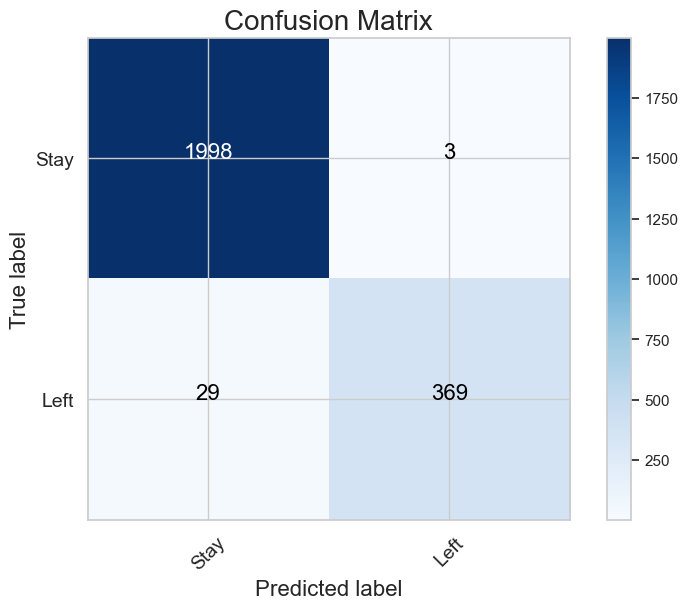

In [104]:
start_rf = time.time()
rf = RandomForestClassifier(n_jobs=-1, random_state=42).fit(X_train_enc, y_train)
end_rf = time.time()

print("RF (weighted): Training time (seconds):", format(end_rf - start_rf))

y_pred_rf = rf.predict(X_test_enc)

cm_rf = confusion_matrix(y_test, y_pred_rf)

plot_confusion_matrix(cm_rf, class_names)

In [105]:
print(start + "\nRF Classification Report:" + end)
target_names = ["Stay", "Left"]

report_df = generate_classification_report(y_test, y_pred_rf, target_names)
metrics_df = calculate_performance_metrics(rf, X_test_enc, y_test, y_pred_rf)
full_report_df_rf = pd.concat([report_df, metrics_df], axis=0)
full_report_df_rf


RF Classification Report:


,precision,recall,f1-score,support,ROC AUC,AP,Balanced accuracy,G-mean,Youden's index,MCC
Stay,0.985693,0.998501,0.992056,2001.000000,NaN,NaN,NaN,NaN,NaN,NaN
Left,0.991935,0.927136,0.958442,398.000000,NaN,NaN,NaN,NaN,NaN,NaN
accuracy,0.986661,0.986661,0.986661,0.986661,NaN,NaN,NaN,NaN,NaN,NaN
macro avg,0.988814,0.962818,0.975249,2399.000000,NaN,NaN,NaN,NaN,NaN,NaN
weighted avg,0.986729,0.986661,0.986479,2399.000000,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,0.976631,0.96194,0.962818,0.962157,0.925636,0.951277


In [106]:
full_report_df_xgb['ROC AUC'][0]


0.9827247180429886

### Model comparison

In [107]:
full_report_df_lr = pd.DataFrame(full_report_df_lr)
full_report_df_lr.index

Index(['Stay', 'Left', 'accuracy', 'macro avg', 'weighted avg', 'ROC AUC',
       'AP', 'Balanced accuracy', 'G-mean', 'Youden's index', 'MCC',
       'Training_time'],
      dtype='object')

In [108]:
full_report_df_lr.loc['Balanced accuracy'].StandardScaler

0.8247283393479139

In [109]:
f1_lr = full_report_df_lr['f1-score'][0]
acc_lr = full_report_df_lr['precision']['accuracy']
roc_auc_lr = full_report_df_lr['StandardScaler']['ROC AUC']
balanced_acc_lr = full_report_df_lr.loc['Balanced accuracy']['StandardScaler']
gmean_lr = full_report_df_lr.loc['G-mean']['StandardScaler']
yi_lr = full_report_df_lr.loc["Youden's index"]['StandardScaler']
mcc_lr = full_report_df_lr.loc['MCC']['StandardScaler']


In [110]:
# DataFrame for model performance metrics
res = pd.DataFrame(
    {
        "Model": ["Logistic Regression", "XGBoost", "LightGBM", "Random Forest"],
        "F1-score": [
            f1_lr,
            full_report_df_xgb["f1-score"]["macro avg"],
            full_report_df_lgb["f1-score"]["macro avg"],
            full_report_df_rf["f1-score"]["macro avg"],
        ],
        "Accuracy": [
            acc_lr,
            full_report_df_xgb["AP"][0],
            full_report_df_lgb["AP"][0],
            full_report_df_rf["AP"][0],
        ],
        "ROC AUC": [
            roc_auc_lr,
            full_report_df_xgb["ROC AUC"][0],
            full_report_df_lgb["ROC AUC"][0],
            full_report_df_rf["ROC AUC"][0],
        ],
        "Balanced accuracy": [
            balanced_acc_lr,
            full_report_df_xgb["Balanced accuracy"][0],
            full_report_df_lgb["Balanced accuracy"][0],
            full_report_df_rf["Balanced accuracy"][0],
        ],
        "Geometric mean (G-mean)": [
            gmean_lr,
            full_report_df_xgb["G-mean"][0],
            full_report_df_lgb["G-mean"][0],
            full_report_df_rf["G-mean"][0],
        ],
        "Youden's index": [
            yi_lr,
            full_report_df_xgb["Youden's index"][0],
            full_report_df_lgb["Youden's index"][0],
            full_report_df_rf["Youden's index"][0],
        ],
        "Matthew’s correlation coefficient (MCC)": [
            mcc_lr,
            full_report_df_xgb["MCC"][0],
            full_report_df_lgb["MCC"][0],
            full_report_df_rf["MCC"][0],
        ],
        "Training_time (seconds)": [
            (end_lr - start_lr),
            (end_xgb - start_xgb),
            (end_lgbmc - start_lgbmc),
            (end_rf - start_rf),
        ],
    }
)

res.sort_values(by=["F1-score", "Training_time (seconds)"], ascending=False)

,Model,F1-score,Accuracy,ROC AUC,Balanced accuracy,Geometric mean (G-mean),Youden's index,Matthew’s correlation coefficient (MCC),Training_time (seconds)
3,Random Forest,0.975249,0.961940,0.976631,0.962818,0.962157,0.925636,0.951277,0.227899
2,LightGBM,0.973812,0.967798,0.982725,0.963325,0.962736,0.926650,0.948176,0.117570
1,XGBoost,0.970791,0.967798,0.982725,0.961319,0.960711,0.922638,0.942036,0.177650
0,Logistic Regression,0.863863,0.794915,0.862143,0.824728,0.823521,0.649457,0.514739,1.944445


## Fine tuning Random Forest

In [111]:
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import time

# Load parameters
params = load_params("best_rf_params.json")
if params:
    rf_tuned = create_model_with_params(params)
    rf_tuned.fit(X_train_enc, y_train)

else:
    print("No parameters file found or file is empty. Ran GridSearchCV instead.")

    class TqdmGridSearchCV(GridSearchCV):
        def _run_search(self, evaluate_candidates):
            """Add tqdm progress bar to the search."""
            super()._run_search(
                lambda params_list: tqdm(
                    evaluate_candidates(params_list), total=len(self.param_grid)
                )
            )

    params_rf = [
        {
            "criterion": ["entropy", "gini"],
            "max_depth": [11, 12],
            "max_features": [9, "auto"],
            "max_samples": [0.8, 0.9],
            "min_samples_leaf": [1, 2],
            "min_samples_split": [7, 8],
            "n_estimators": [50, 51],
            "oob_score": [True, False],
            "class_weight": ["balanced", "balanced_subsample", None],
        }
    ]

    scores = ["balanced_accuracy", "average_precision", "roc_auc"]

    grid_rf = TqdmGridSearchCV(
        RandomForestClassifier(n_jobs=-1, random_state=42),
        param_grid=params_rf,
        scoring=scores,
        refit="roc_auc",
        n_jobs=-1,
        cv=5,
    )

    start_rf_tuned = time.time()
    grid_rf.fit(X_train_enc, y_train)
    end_rf_tuned = time.time()
    print(
        "RF (tuned): Training time (seconds) =", format(end_rf_tuned - start_rf_tuned)
    )
    dump_params(grid_rf.get_params(), "best_rf_params.json")


RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=12, max_features='auto', max_samples=0.8,
                       min_samples_leaf=2, min_samples_split=8, n_estimators=51,
                       n_jobs=-1, oob_score=True, random_state=42)

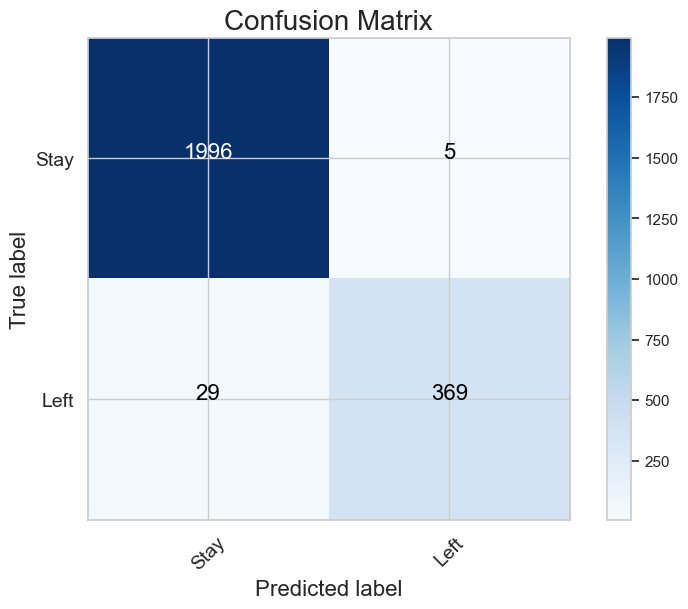

In [112]:
class_names = ["Stay", "Left"]
y_pred_rf_tuned = rf_tuned.predict(X_test_enc)
cm_rf_tuned = confusion_matrix(y_test, y_pred_rf_tuned)
plot_confusion_matrix(cm_rf_tuned, class_names)

In [113]:
print("\nClassification report:")
target_names = ['Stay','Left']
print(classification_report(y_test,y_pred_rf_tuned,target_names=target_names,digits=4))

roc_auc_rf_tuned=roc_auc_score(y_test, rf_tuned.predict_proba(X_test_enc)[:, 1])
ap_rf_tuned=average_precision_score(y_test, rf_tuned.predict_proba(X_test_enc)[:, 1])
balanced_accuracy_rf_tuned=balanced_accuracy_score(y_test,y_pred_rf_tuned)
gmeans_rf_tuned=geometric_mean_score(y_test,y_pred_rf_tuned)
youden_rf_tuned=balanced_accuracy_score(y_test,y_pred_rf_tuned,adjusted=True)
mcc_rf_tuned=matthews_corrcoef(y_test,y_pred_rf_tuned)
  
print("Area Under the Receiver Operating Characteristic Curve (ROC AUC): {:.5f}".format(roc_auc_rf_tuned))
print("Average precision (AP)                                          : {:.5f}".format(ap_rf_tuned))
print("Balanced accuracy                      : {:.5f}".format(balanced_accuracy_rf_tuned)) 
print("Geometric mean (G-mean)                : {:.5f}".format(gmeans_rf_tuned))
print("Youden's index                         : {:.5f}".format(youden_rf_tuned)) 
print("Matthew’s correlation coefficient (MCC): {:.5f}".format(mcc_rf_tuned))


Classification report:
              precision    recall  f1-score   support

        Stay     0.9857    0.9975    0.9916      2001
        Left     0.9866    0.9271    0.9560       398

    accuracy                         0.9858      2399
   macro avg     0.9862    0.9623    0.9738      2399
weighted avg     0.9858    0.9858    0.9856      2399

Area Under the Receiver Operating Characteristic Curve (ROC AUC): 0.98293
Average precision (AP)                                          : 0.96841
Balanced accuracy                      : 0.96232
Geometric mean (G-mean)                : 0.96168
Youden's index                         : 0.92464
Matthew’s correlation coefficient (MCC): 0.94817


#### Comparing Train Set vs Test Set

In [114]:
roc_auc_rf_train=roc_auc_score(y_train, rf_tuned.predict_proba(X_train_enc)[:, 1])
ap_rf_train=average_precision_score(y_train, rf_tuned.predict_proba(X_train_enc)[:, 1])
balanced_accuracy_rf_train=balanced_accuracy_score(y_train,rf_tuned.predict(X_train_enc))
gmeans_rf_train=geometric_mean_score(y_train,rf_tuned.predict(X_train_enc))
youden_rf_train=balanced_accuracy_score(y_train,rf_tuned.predict(X_train_enc),adjusted=True)
mcc_rf_train=matthews_corrcoef(y_train,rf_tuned.predict(X_train_enc))

pdf=pd.DataFrame({"Model"            :['Training set',      'Test set'],
              "Area Under the Receiver Operating Characteristic Curve (ROC AUC)":[roc_auc_rf_train,roc_auc_rf_tuned],
              "Average precision (AP)":[ap_rf_train,ap_rf_tuned],
              'Balanced accuracy':[balanced_accuracy_rf_train,balanced_accuracy_rf_tuned],
              "Geometric mean (G-mean)":[gmeans_rf_train,gmeans_rf_tuned],
              "Youden's index":[youden_rf_train,youden_rf_tuned],
              "Matthew’s correlation coefficient (MCC)":[mcc_rf_train,mcc_rf_tuned]
             })

pd.DataFrame(pdf).set_index('Model').transpose()

del pdf

# Confusion matrix comparison

y_pred_rf_train=rf_tuned.predict(X_train_enc)

train_pdf=pd.DataFrame.from_dict(classification_report(y_train,y_pred_rf_train,target_names=target_names,digits=4,output_dict=True)).transpose()
tuned_pdf=pd.DataFrame.from_dict(classification_report(y_test,y_pred_rf_tuned,target_names=target_names,digits=4,output_dict=True)).transpose()

pd.concat([train_pdf, tuned_pdf], axis=1, keys=['Train Set', 'Test Set'])

del train_pdf, tuned_pdf

Model,Training set,Test set
Area Under the Receiver Operating Characteristic Curve (ROC AUC),0.999485,0.982929
Average precision (AP),0.997376,0.968414
Balanced accuracy,0.966986,0.962318
Geometric mean (G-mean),0.966509,0.961675
Youden's index,0.933972,0.924637
Matthew’s correlation coefficient (MCC),0.953589,0.948174


Train Set                                   Test Set            \
             precision    recall  f1-score      support precision    recall   
Stay          0.987498  0.997375  0.992412  7999.000000  0.985679  0.997501   
Left          0.986120  0.936598  0.960721  1593.000000  0.986631  0.927136   
accuracy      0.987281  0.987281  0.987281     0.987281  0.985827  0.985827   
macro avg     0.986809  0.966986  0.976567  9592.000000  0.986155  0.962318   
weighted avg  0.987270  0.987281  0.987149  9592.000000  0.985837  0.985827   

                                     
              f1-score      support  
Stay          0.991555  2001.000000  
Left          0.955959   398.000000  
accuracy      0.985827     0.985827  
macro avg     0.973757  2399.000000  
weighted avg  0.985649  2399.000000

The differences between the training and test set performance metrics are relatively minor, which is a good indication that the model is generalizing well and not overfitting to the training data.

The metrics suggest a robust model with strong predictive power. However, there's always a slight decrease in most metrics from the training to the test set, which is normal as the test set represents new, unseen data for the model.

#### Feature importance

<Axes: xlabel='Importance', ylabel='Feature'>

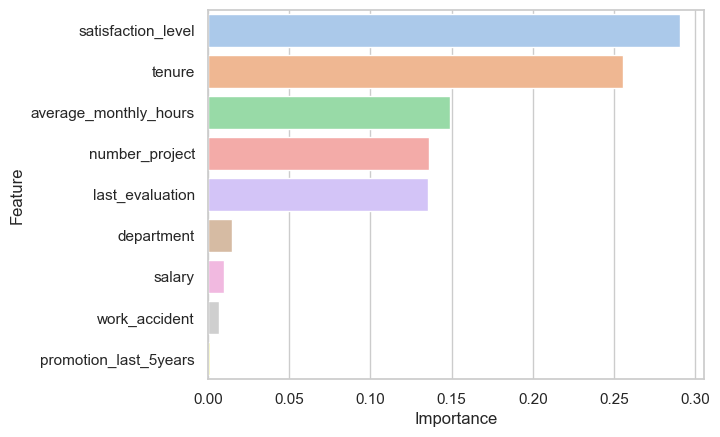

In [115]:
feature_importances = pd.DataFrame({'Feature': X.columns,'Importance': rf_tuned.feature_importances_})
feature_importances = feature_importances.sort_values('Importance', ascending=False)
sns.barplot(x="Importance", y="Feature", data=feature_importances)

In [116]:
import pickle

filename = "model.sav"
pickle.dump(rf_tuned, open(filename, "wb"))

# Load the model from disk
loaded_model = pickle.load(open(filename, "rb"))
print(loaded_model)


RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=12, max_features='auto', max_samples=0.8,
                       min_samples_leaf=2, min_samples_split=8, n_estimators=51,
                       n_jobs=-1, oob_score=True, random_state=42)


#### The employees that stayed, but are likely to quit

In [117]:
stayed = df[df["left"] == 0]
le = LabelEncoder()
stayed["department"] = le.fit_transform(stayed["department"])
stayed = stayed.drop(["left", "overtime"], axis=1)

y_pred_risk = loaded_model.predict(stayed)
y_pred_risk.sum()
df[df.index.isin(stayed.index[y_pred_risk == 1])].head(5)

26

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary,overtime
2416,0.92,0.97,4,238,5,1,0,0,support,1.0,1
3781,0.86,0.96,5,238,5,0,0,0,technical,0.0,1
5566,0.84,0.84,6,261,5,0,0,0,product_mng,0.0,1
5848,0.77,0.85,5,221,5,0,0,0,technical,0.0,1
5995,0.80,0.99,4,255,5,1,0,0,technical,0.0,1


In [118]:
# Predict the risk probabilities
risk_probabilities = loaded_model.predict_proba(stayed)

# Assuming that the risk class is the second one (index 1)
risk_probabilities = risk_probabilities[:, 1]

# Add these probabilities to the original dataframe for analysis
df_stayed_with_risk = df[df.index.isin(stayed.index)].copy()
df_stayed_with_risk['Risk_Probability'] = risk_probabilities

# Display the first 5 instances with their risk probabilities
df_stayed_with_risk.head(5)

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary,overtime,Risk_Probability
634,0.84,0.89,4,187,2,1,0,0,IT,0.0,1,0.003004
2001,0.58,0.74,4,215,3,0,0,0,sales,0.0,1,0.010747
2002,0.82,0.67,2,202,3,0,0,0,sales,0.0,1,0.015042
2003,0.45,0.69,5,193,3,0,0,0,sales,0.0,1,0.119368
2004,0.78,0.82,5,247,3,0,0,0,sales,0.0,1,0.071274


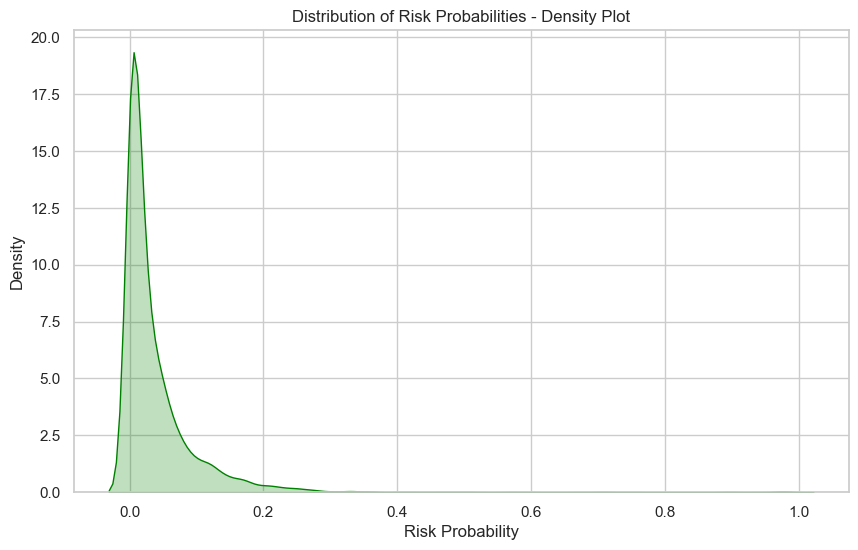

In [119]:
# Density Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(df_stayed_with_risk['Risk_Probability'], shade=True, color='green')
plt.title('Distribution of Risk Probabilities - Density Plot')
plt.xlabel('Risk Probability')
plt.ylabel('Density')
plt.grid(True)
plt.show();

**Even though the model predicts that 26 employees are likely to quit, the risk is low. Instances with high risk are rare.**

## **Conclusion, Recommendations, Next Steps**


**Conclusion:**

Based on the analysis conducted, we have gained valuable insights into the factors influencing employee retention at Salifort Motors. The random forest model, after hyperparameter tuning, has demonstrated strong performance in predicting employee attrition. The evaluation metrics and classification report indicate high accuracy, precision, recall, and F1-score for both the training and test sets. This suggests that the model generalizes well and can effectively identify employees at risk of leaving the company.

**Recommendations:**

- Enhance Job Satisfaction: Salifort Motors should continuously gauge and improve job satisfaction through feedback and well-being initiatives.

- Competitive Compensation: Maintain industry-competitive salaries and offer performance incentives to keep and attract skilled employees.

- Data-Driven Decisions: Expand data collection to refine the turnover prediction model and highlight actionable retention strategies.

- Workload Oversight: Monitor and adjust employee workloads to prevent burnout, ensuring that overtime is both fair and compensated.
- Work-Life Harmony: Implement flexible and innovative work arrangements to bolster work-life balance, such as hybrid or reduced-hour schedules.
- Utilize Analytics: Use predictive analytics in conjunction with HR tools for proactive retention management.
- Invest in Development: Prioritize training programs to boost proficiency and job satisfaction, mitigating turnover.





